In [1]:
import numpy as np

train = np.loadtxt("mnist_train.csv", delimiter = ',')
test = np.loadtxt("mnist_test.csv", delimiter = ',')

In [2]:
print("Number of training datapoints: {}".format(train.shape[0]))
print("Number of testing datapoints: {}".format(test.shape[0]))
print("Number of features : {}".format(train.shape[1]))

Number of training datapoints: 60000
Number of testing datapoints: 10000
Number of features : 785


In [22]:
train_data = []
test_data = []
for i in range(30000):
    if train[i][0] == 6 or train[i][0] == 8:
        train_data.append(train[i])
for j in range(10000):
    if test[j][0] == 6 or test[j][0] == 8:
        test_data.append(test[j])

train_data = np.array(train_data)
test_data = np.array(test_data)

In [23]:
size_train = train_data.shape[0]
size_test = test_data.shape[0]

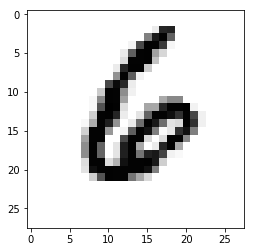

In [55]:
import matplotlib.pyplot as plt

image_size = 28
img = train_data[:, 1:][0].reshape((image_size, image_size))
plt.imshow(img, cmap="Greys")
plt.show()

In [24]:
train_data_features = train_data[:size_train, 1:]
train_data_labels = train_data[:size_train, :1].reshape(size_train,)
test_data_features = test_data[:size_test,1:]
test_data_labels = test_data[:size_test,0].reshape(size_test,)

In [25]:
print("Number of training datapoints: {}".format(train_data_features.shape[0]))
print("Number of testing datapoints: {}".format(test_data_features.shape[0]))

Number of training datapoints: 5850
Number of testing datapoints: 1932


In [26]:
sample_train = train_data_features
label_train = train_data_labels
sample_test = test_data_features
label_test = test_data_labels

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Now reduce number of features to number of qubits
pca = PCA(n_components=3).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

print("Number of features : {}".format(sample_train.shape[1]))

Number of features : 3


In [28]:
# Scale to the range (-1,1)
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

In [46]:
from qiskit_machine_learning.datasets.dataset_helper import features_and_labels_transform

class_labels = [r"A",r"B"]
one_hot = True
training_size = 100
test_size = 25

training_input = {key: (sample_train[label_train == k, :])[:training_size] for k,key in [(6,'A'),(8,'B')]
    }
test_input = {
        key: (sample_test[label_test == k, :])[:test_size] 
        for k, key in [(6,'A'),(8,'B')]
    }

training_feature_array, training_label_array = features_and_labels_transform(training_input, class_labels,one_hot)
test_feature_array, test_label_array = features_and_labels_transform(test_input, class_labels,one_hot)

In [36]:
training_feature_array.shape

(100, 3)

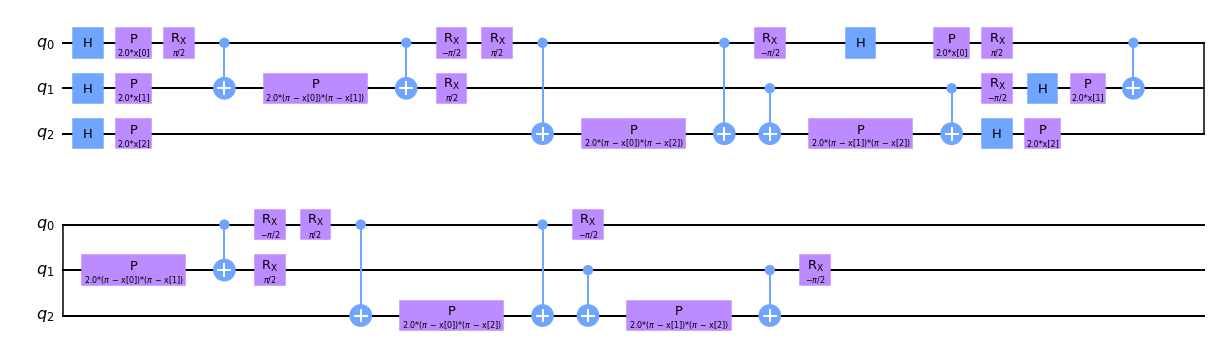

In [37]:
from qiskit.circuit.library import PauliFeatureMap 

feature_map = PauliFeatureMap(feature_dimension=3, reps=2, paulis = ['Z','ZY'])
feature_map.draw('mpl')

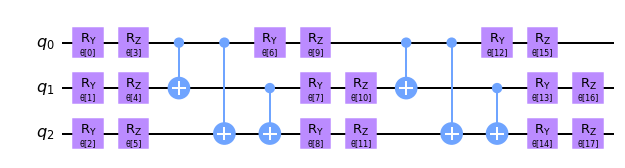

In [38]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits = 3,entanglement = "full",reps = 2)
ansatz.draw('mpl')

In [33]:
from qiskit.algorithms.optimizers import SLSQP

cls_opt = SLSQP(maxiter = 1000)

In [47]:
from qiskit import *
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms import VQC

seed = 12345
backend = Aer.get_backend('qasm_simulator')
backend_options = {"method": "statevector"}

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, 
                                   backend_options=backend_options)
vqc = VQC(feature_map=feature_map,
                  ansatz=ansatz,
                  optimizer=cls_opt,loss='cross_entropy',
                  quantum_instance= quantum_instance
                  )
vqc.fit(training_feature_array, training_label_array)


In [48]:
test_label_pred = vqc.predict(test_feature_array)

In [49]:
def binary(array):
    true = []
    for i in range(len((array))):
        if array[i][1] == 0:
            true.append(6)
        else:
            true.append(8)
    return true

In [50]:
true_val = binary(test_label_array)
pred_val = binary(test_label_pred)

In [51]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_val,pred_val)
print(cm)

[[22  3]
 [ 2 23]]


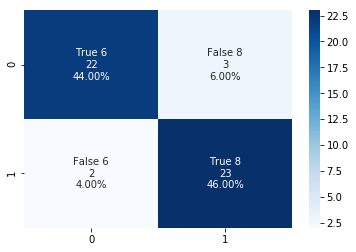

In [52]:
import seaborn as sns


group_names = ['True 6','False 8','False 6','True 8']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [53]:
score = vqc.score(test_feature_array, test_label_array)
print('Testing accuracy: {:0.2f} %'.format(score*100))

Testing accuracy: 90.00 %
